In [2]:
import os
import json
import warnings
import torch
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

In [3]:
import geopandas as gpd
from cartopy import crs as ccrs
import cartopy.feature as cfeature
import matplotlib.patches as patches

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=FutureWarning)

    # Load the world shapefile provided by geopandas
    world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

In [3]:
# Set environment variables to help manage CUDA memory
os.environ['CUDA_VISIBLE_DEVICES'] = "MIG-214cfb66-c8e5-57f2-b101-90f2cca83fad"

torch.cuda.empty_cache()
torch.set_float32_matmul_precision('medium')

if torch.cuda.is_available():
    print(torch.cuda.get_device_name(0))

NVIDIA A100 80GB PCIe MIG 4g.40gb


In [4]:
for root, dirs, files in os.walk('/home/serfani/serfani_data1/E3OMA_2D_2010'):
    
    sorted_files = sorted(files)
    list1 = [os.path.join(root, file) for file in sorted_files if file.split(".")[1] == 'aijlh1E3oma']   # Velocity Fields (time, level, lat, lon)
    list2 = [os.path.join(root, file) for file in sorted_files if file.split(".")[1] == 'cijh1E3oma']    # Precipitation (time, lat, lon)
    list3 = [os.path.join(root, file) for file in sorted_files if file.split(".")[1] == 'tNDaijh1E3oma'] # Clay-BCB Src (time, lat, lon)
    list4 = [os.path.join(root, file) for file in sorted_files if file.split(".")[1] == 'taijlh1E3oma']  # Aerosols Mixing Ratio (time, level, lat, lon)

print(len(list1), len(list2), len(list3), len(list4))

730 730 730 730


In [4]:
ds1 = xr.open_mfdataset(list1[365:365+5])

warnings.filterwarnings("ignore", message="Converting a CFTimeIndex with dates from a non-standard calendar")
ds1['time'] = ds1.indexes['time'].to_datetimeindex()  # 365 x 48 -> 17520

ds1

<xarray.Dataset> Size: 6GB
Dimensions:  (time: 240, lat: 90, lon: 144, level: 62)
Coordinates:
  * lon      (lon) float32 576B -178.8 -176.2 -173.8 ... 173.8 176.2 178.8
  * lat      (lat) float32 360B -90.0 -87.0 -85.0 -83.0 ... 83.0 85.0 87.0 90.0
  * level    (level) float32 248B 1.0 2.0 3.0 4.0 5.0 ... 59.0 60.0 61.0 62.0
  * time     (time) datetime64[ns] 2kB 2011-01-01T00:15:00 ... 2011-01-05T23:...
Data variables:
    axyp     (time, lat, lon) float32 12MB dask.array<chunksize=(48, 90, 144), meta=np.ndarray>
    u        (time, level, lat, lon) float32 771MB dask.array<chunksize=(48, 62, 90, 144), meta=np.ndarray>
    v        (time, level, lat, lon) float32 771MB dask.array<chunksize=(48, 62, 90, 144), meta=np.ndarray>
    omega    (time, level, lat, lon) float32 771MB dask.array<chunksize=(48, 62, 90, 144), meta=np.ndarray>
    p_3d     (time, level, lat, lon) float32 771MB dask.array<chunksize=(48, 62, 90, 144), meta=np.ndarray>
    z        (time, level, lat, lon) float32 771MB dask.array<chunksize=(48, 62, 90, 144), meta=np.ndarray>
    t        (time, level, lat, lon) float32 771MB dask.array<chunksize=(48, 62, 90, 144), meta=np.ndarray>
    th       (time, level, lat, lon) float32 771MB dask.array<chunksize=(48, 62, 90, 144), meta=np.ndarray>
    q        (time, level, lat, lon) float32 771MB dask.array<chunksize=(48, 62, 90, 144), meta=np.ndarray>
Attributes:
    xlabel:   E3oma_ai_2010 tests (test run)

### Forcings

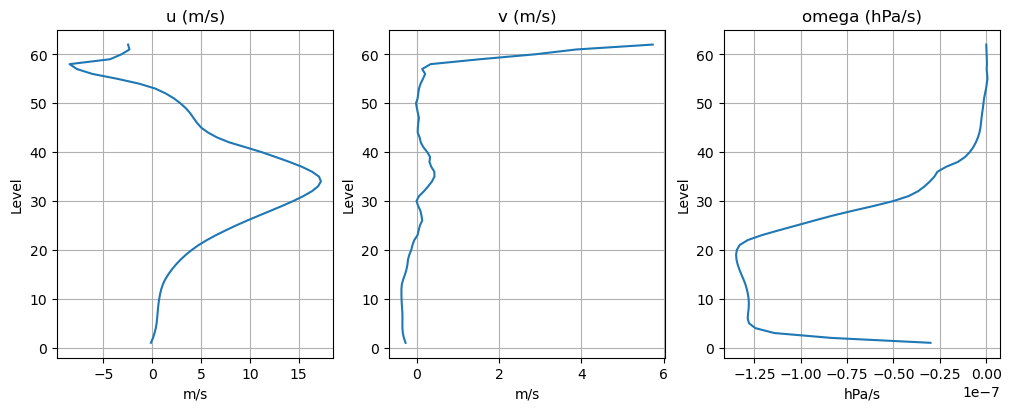

In [ ]:
weights = np.cos(np.deg2rad(ds1.lat))
weights.name = "weights"

ds1_avg = ds1.weighted(weights).mean(dim=("lat", "lon", "time"))

fig, axs = plt.subplots(ncols=3, nrows=1, figsize=(10, 4), constrained_layout=True)

var1 = ["u", "v", "omega"]
unit1 = ['m/s', 'm/s', 'hPa/s']

for idx, ax in enumerate(axs.flat):
    if idx < len(var1):  # Ensure we don't exceed the number of variables
        
        # Plot the time series
        ds1_avg[f'{var1[idx]}'].plot(ax=ax, y='level', yincrease=True)
        
        # Set titles and labels
        ax.set_title(f'{var1[idx]} ({unit1[idx]})')
        ax.set_xlabel(f'{unit1[idx]}')
        ax.set_ylabel('Level')
        ax.grid()
    else:
        # Turn off unused subplots
        ax.set_visible(False)

plt.show()

###

In [6]:
ds4 = xr.open_mfdataset(list4[365:365+365])

warnings.filterwarnings("ignore", message="Converting a CFTimeIndex with dates from a non-standard calendar")
ds4['time'] = ds4.indexes['time'].to_datetimeindex()  # 365 x 48 -> 17520

ds4

<xarray.Dataset> Size: 282GB
Dimensions:   (time: 17520, lat: 90, lon: 144, level: 62)
Coordinates:
  * lon       (lon) float32 576B -178.8 -176.2 -173.8 ... 173.8 176.2 178.8
  * lat       (lat) float32 360B -90.0 -87.0 -85.0 -83.0 ... 83.0 85.0 87.0 90.0
  * level     (level) float32 248B 1.0 2.0 3.0 4.0 5.0 ... 59.0 60.0 61.0 62.0
  * time      (time) datetime64[ns] 140kB 2011-01-01T00:15:00 ... 2011-12-31T...
Data variables:
    axyp      (time, lat, lon) float32 908MB dask.array<chunksize=(48, 90, 144), meta=np.ndarray>
    Clay      (time, level, lat, lon) float32 56GB dask.array<chunksize=(48, 62, 90, 144), meta=np.ndarray>
    seasalt1  (time, level, lat, lon) float32 56GB dask.array<chunksize=(48, 62, 90, 144), meta=np.ndarray>
    BCB       (time, level, lat, lon) float32 56GB dask.array<chunksize=(48, 62, 90, 144), meta=np.ndarray>
    OCB       (time, level, lat, lon) float32 56GB dask.array<chunksize=(48, 62, 90, 144), meta=np.ndarray>
    airmass   (time, level, lat, lon) float32 56GB dask.array<chunksize=(48, 62, 90, 144), meta=np.ndarray>
Attributes:
    xlabel:   E3oma_ai_2010 tests (test run)

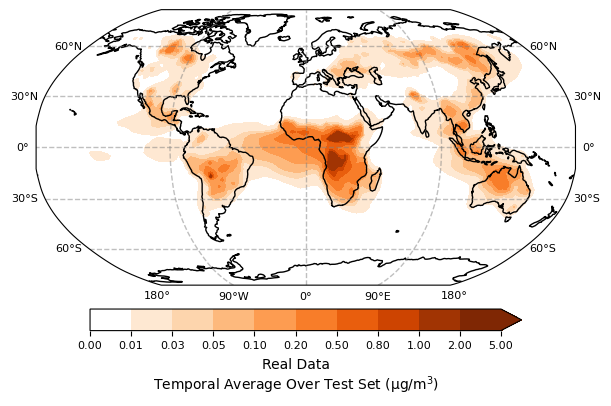

In [ ]:
import matplotlib.colors as mcolors
import matplotlib.ticker as mticker

fig, (ax1) = plt.subplots(ncols=1, nrows=1, figsize=(6, 4), subplot_kw={'projection': ccrs.Robinson()}, constrained_layout=True)

ax1.coastlines()

# Get the data for the current level
data1 = ds4['BCB'].isel(level=0).mean(dim=("time")).values
data1 = data1 * 0.01 * 1.25

# Define stepwise colors and corresponding boundaries
colors = plt.cm.Oranges(np.linspace(0, 1, 10))  # Adjust colors as needed
colors[0] = [1, 1, 1, 1]  # Set the first color to white
bounds = np.linspace(0, .1, 11)  # Define boundaries
# bounds[1] = 0.01
bounds = [0, 0.01, 0.03, 0.05, 0.1, 0.2, 0.5, 0.8, 1, 2, 5]

# Create a colormap and normalization
cmap = mcolors.ListedColormap(colors)
norm = mcolors.BoundaryNorm(bounds, cmap.N)

# Create a meshgrid for longitude and latitude
lon, lat = np.meshgrid(ds4['lon'], ds4['lat'])

im1 = ax1.contourf(
    lon, lat, data1,
    transform=ccrs.PlateCarree(),
    levels=bounds, 
    cmap=cmap, norm=norm, extend='max'
)


gl1 = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=False, linewidth=1, color='gray', alpha=0.5, linestyle='--')


# Add an individual colorbar for each subplot
cbar = plt.colorbar(im1, ax=ax1, orientation='horizontal', pad=0.02, shrink=0.8, extend='max')
cbar.set_label('Real Data' '\n' r'Temporal Average Over Test Set ($\mathrm{\mu g} / \mathrm{m}^{\mathrm{3}}$)', rotation=0, labelpad=5, fontsize=10)
cbar.ax.tick_params(labelsize=8)  # Adjust the font size here
cbar.set_ticks(bounds)  # Explicitly set the ticks


plt.show()

In [ ]:
weights = np.cos(np.deg2rad(ds4.lat))
weights.name = "weights"

ds4_avg = ds4.weighted(weights).mean(dim=("lat", "lon"))

fig, ax = plt.subplots(1, 1, figsize=(18, 5))

ax.plot(ds4_avg.indexes['time'], ds4_avg['BCB'].isel(level=0), alpha=0.6, label='Level-0')

ax.tick_params(axis='x', labelrotation=45)
ax.grid()

plt.legend()
plt.show()

In [5]:
ds3 = xr.open_mfdataset(list3[365:365+365])

warnings.filterwarnings("ignore", message="Converting a CFTimeIndex with dates from a non-standard calendar")
ds3['time'] = ds3.indexes['time'].to_datetimeindex()  # 365 x 48 -> 17520

ds3

<xarray.Dataset> Size: 4GB
Dimensions:          (time: 17520, lat: 90, lon: 144)
Coordinates:
  * lon              (lon) float32 576B -178.8 -176.2 -173.8 ... 176.2 178.8
  * lat              (lat) float32 360B -90.0 -87.0 -85.0 ... 85.0 87.0 90.0
  * time             (time) datetime64[ns] 140kB 2011-01-01T00:15:00 ... 2011...
Data variables:
    axyp             (time, lat, lon) float32 908MB dask.array<chunksize=(48, 90, 144), meta=np.ndarray>
    Clay_emission    (time, lat, lon) float32 908MB dask.array<chunksize=(48, 90, 144), meta=np.ndarray>
    BCB_biomass_src  (time, lat, lon) float32 908MB dask.array<chunksize=(48, 90, 144), meta=np.ndarray>
    OCB_biomass_src  (time, lat, lon) float32 908MB dask.array<chunksize=(48, 90, 144), meta=np.ndarray>
Attributes:
    xlabel:   E3oma_ai_2010 tests (test run)

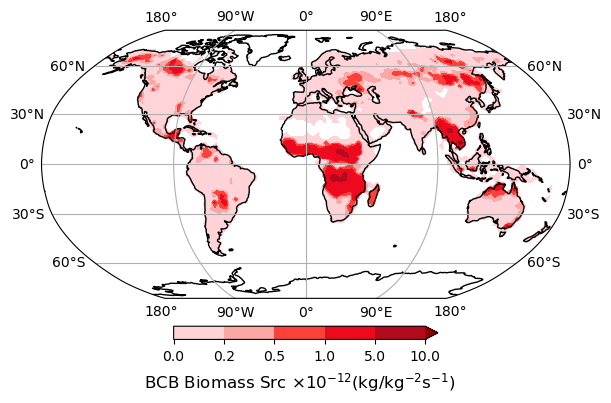

In [ ]:
import matplotlib.colors as mcolors
import matplotlib.ticker as mticker

fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(6, 4), subplot_kw={'projection': ccrs.Robinson()}, constrained_layout=True)

# Create a meshgrid for longitude and latitude
lon, lat = np.meshgrid(ds3['lon'], ds3['lat'])

data = ds3['BCB_biomass_src'].mean(dim='time')
data = np.where(data <= 0.0, np.nan, data)
ax.coastlines()

colors = [(0.0, 'mistyrose'), (0.025, 'pink'), (0.05, 'salmon'), (0.1, 'red'), (0.5, 'crimson'), (1.0, 'darkred')]
cmap = mcolors.LinearSegmentedColormap.from_list('custom_cmap', colors, N=256)

im = ax.contourf(
    lon, lat, data,
    transform=ccrs.PlateCarree(),
    levels=[0, 0.25, 0.5, 1.0, 5.0, 10], 
    cmap=cmap, extend='max'
)

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
gl.xlocator = mticker.FixedLocator([-180, -90, 0, 90, 180])


# Add an individual colorbar for each subplot
cbar = plt.colorbar(im, ax=ax, orientation='horizontal', pad=0.02, shrink=0.5)
cbar.set_label(r'BCB Biomass Src $ \times 10^{-12} (\mathrm{kg} / \mathrm{kg}^{-2} \mathrm{s}^{-1}$)', rotation=0, labelpad=5, fontsize=12)
cbar.ax.tick_params(labelsize=10)  # Adjust the font size here
cbar.ax.xaxis.set_major_formatter(mticker.FormatStrFormatter('%.1f'))

plt.show()

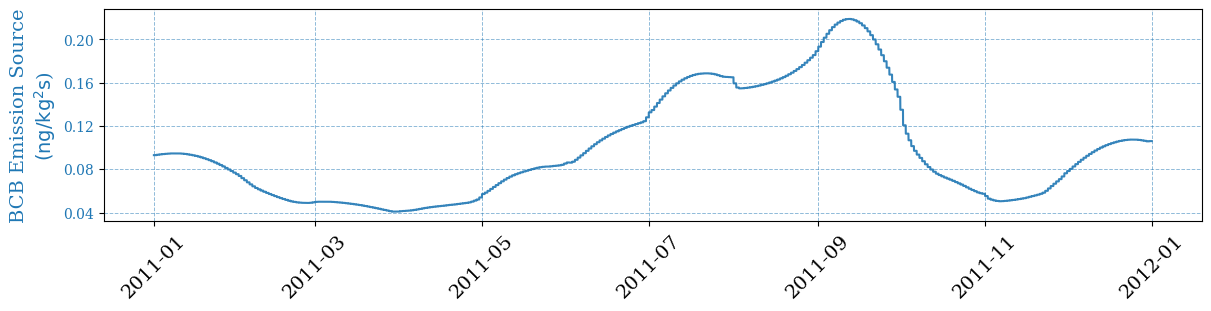

In [8]:
# Define Font style
plt.rcParams.update({'font.family': 'serif'})
from matplotlib.ticker import MaxNLocator

fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(12, 3), constrained_layout=True)

weights = np.cos(np.deg2rad(ds3.lat))
weights.name = "weights"


conc = ds4['BCB'].isel(level=0).weighted(weights).mean(dim=("lat", "lon")).values
conc = conc * 0.01 * 1.25

src = ds3['BCB_biomass_src'].weighted(weights).mean(dim=("lat", "lon")).values

time_axis = ds3.indexes['time']

# Plot the first axis (src)
line1 = ax1.plot(time_axis, src, alpha=0.9, label='BCB Emission Source', color='tab:blue')
ax1.yaxis.set_major_locator(MaxNLocator(nbins=5))
# ax1.set_ylabel('BCB Emission Source' '\n' r'$\times 10^{-12} (\mathrm{kg} / \mathrm{kg}^{2} \mathrm{s}$)', fontsize=14, color='tab:blue')
ax1.set_ylabel('BCB Emission Source' '\n' r'$(\mathrm{ng} / \mathrm{kg}^{2} \mathrm{s}$)', fontsize=14, color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.tick_params(axis='x', labelrotation=45, labelsize=14)
ax1.grid(color='tab:blue', linestyle='--', linewidth=0.7, alpha=0.5)  # Blue grid for ax1


# Create a second y-axis for conc
# ax2 = ax1.twinx()
# line2 = ax2.plot(time_axis, conc, alpha=0.9, label='BCB Concentration', color='tab:orange')
# ax2.yaxis.set_major_locator(MaxNLocator(nbins=5))
# ax2.set_ylabel('BCB Concentration' '\n' r'$(\mathrm{\mu g} / \mathrm{m}^{\mathrm{3}})$', fontsize=14, color='tab:orange')
# ax2.tick_params(axis='y', labelcolor='tab:orange')
# ax2.grid(color='tab:orange', linestyle='--', linewidth=0.7, alpha=0.5)  # Orange grid for ax2

# # Combine legends from both axes
# lines = line1 + line2
# labels = [l.get_label() for l in lines]
# ax1.legend(lines, labels, loc='upper left', fontsize=12)

plt.show()

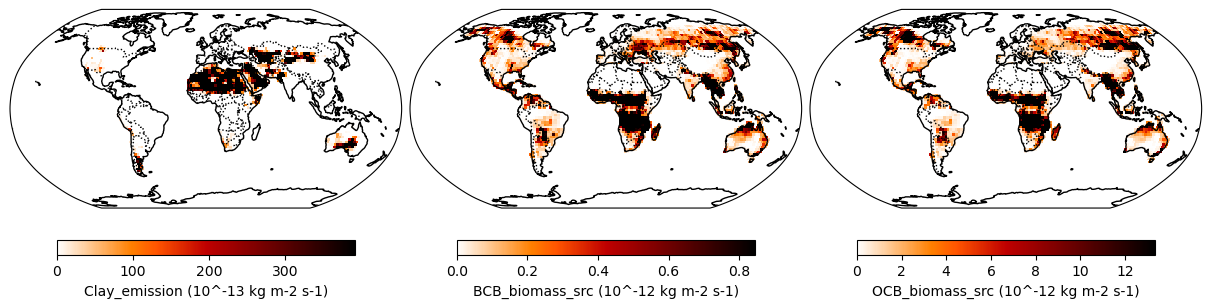

In [18]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12, 4), constrained_layout=True, subplot_kw={'projection': ccrs.Robinson()})

var5 = ["Clay_emission", "BCB_biomass_src", "OCB_biomass_src"]
unit5 = ['10^-13 kg m-2 s-1', '10^-12 kg m-2 s-1', '10^-12 kg m-2 s-1']

for idx, ax in enumerate(axs.flat):
    if idx < len(var5):  # Ensure we don't exceed the number of variables
        # Plot the data
        im = ds5[f'{var5[idx]}'].mean(axis=0).plot(ax=ax,  transform=ccrs.PlateCarree(), robust=True, cmap='gist_heat_r', add_colorbar=False)
        
        # Add coastlines and borders
        ax.coastlines()
        ax.add_feature(cfeature.BORDERS, linestyle=':')
        # ax.set_title(f'')
        
        # Add a color bar below each subplot
        cbar = fig.colorbar(im, ax=ax, orientation='horizontal', fraction=0.05, pad=0.1)
        cbar.set_label(f'{var5[idx]} ({unit5[idx]})')  # Label the color bar with the variable name
    else:
        # Turn off unused subplots
        ax.set_visible(False)

# Show the plot
plt.show()

In [20]:
weights = np.cos(np.deg2rad(ds5.lat))
weights.name = "weights"

ds5_avg = ds5.weighted(weights).mean(dim=("lat", "lon"))

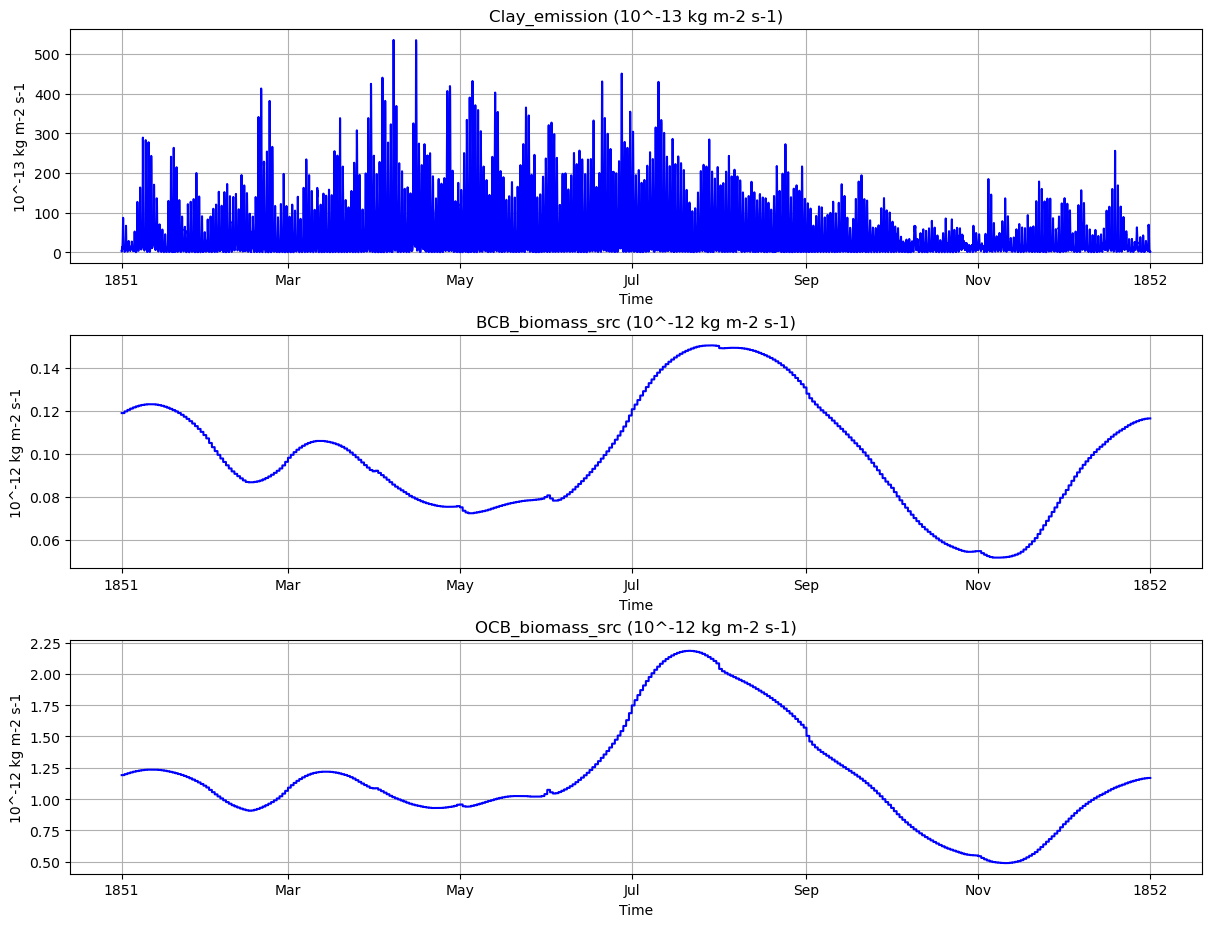

In [21]:
fig, axs = plt.subplots(nrows=5, ncols=1, figsize=(12, 14), constrained_layout=True)

var5 = ["Clay_emission", "BCB_biomass_src", "OCB_biomass_src"]
unit5 = ['10^-13 kg m-2 s-1', '10^-12 kg m-2 s-1', '10^-12 kg m-2 s-1']

for idx, ax in enumerate(axs.flat):
    if idx < len(var5):  # Ensure we don't exceed the number of variables
        
        # Plot the time series
        ds5_avg[f'{var5[idx]}'].plot(ax=ax, label=f'{var5[idx]}', color='b')
        
        # Set titles and labels
        ax.set_title(f'{var5[idx]} ({unit5[idx]})')
        ax.set_xlabel('Time')
        ax.set_ylabel(f'{unit5[idx]}')
        ax.grid()
    else:
        # Turn off unused subplots
        ax.set_visible(False)

# Show the plot
plt.show()

### Calculation of descriptive statistics of input/output variables

In [9]:
ds = xr.open_mfdataset(list6[365:365+3])
ds

<xarray.Dataset> Size: 470MB
Dimensions:  (time: 144, lat: 90, lon: 144, level: 62)
Coordinates:
  * lon      (lon) float32 576B -178.8 -176.2 -173.8 ... 173.8 176.2 178.8
  * lat      (lat) float32 360B -90.0 -87.0 -85.0 -83.0 ... 83.0 85.0 87.0 90.0
  * level    (level) float32 248B 1.0 2.0 3.0 4.0 5.0 ... 59.0 60.0 61.0 62.0
  * time     (time) object 1kB 1851-01-01 00:15:00 ... 1851-01-03 23:45:00
Data variables:
    axyp     (time, lat, lon) float32 7MB dask.array<chunksize=(48, 90, 144), meta=np.ndarray>
    cfrad    (time, level, lat, lon) float32 463MB dask.array<chunksize=(48, 62, 90, 144), meta=np.ndarray>
Attributes:
    xlabel:   E3oma_ai_1850 tests (test run)

avg1: 24.8843, std1: 43.2342
avg2: 16.1301, std2: 36.7808
avg3: 16.1499, std3: 36.7991


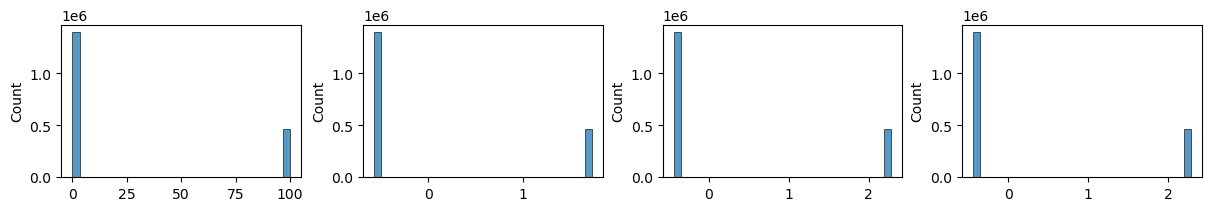

In [10]:
# Histogram
from scipy.stats import skew, kurtosis, zscore
import seaborn as sns

weights = np.cos(np.deg2rad(ds.lat))
weights.name = "weights"

v = ds['cfrad'].isel(level=0)
area = ds['axyp']

avg1 = v.mean(dim=("lat", "lon", "time")).values
std1 = v.std(dim=("lat", "lon", "time")).values
avg2 = v.weighted(weights).mean(dim=("lat", "lon", "time")).values
std2 = v.weighted(weights).std(dim=("lat", "lon", "time")).values

weighted_mean = np.average(v.values, weights=area.values)
weighted_std = np.sqrt(np.average((v.values - weighted_mean)**2, weights=area.values))

print(f'avg1: {avg1:.4f}, std1: {std1:.4f}')
print(f'avg2: {avg2:.4f}, std2: {std2:.4f}')
print(f'avg3: {weighted_mean:.4f}, std3: {weighted_std:.4f}')

v1 = (v.values - avg1) / std1
v2 = (v.values - avg2) / std2 
v3 = (v.values - weighted_mean) / weighted_std

fig, axs = plt.subplots(nrows=1, ncols=4 , figsize=(12,2), constrained_layout=True)

sns.histplot(x=v.values.flatten(), bins=30, ax=axs[0])
sns.histplot(x=v1.flatten(), bins=30, ax=axs[1])
sns.histplot(x=v2.flatten(), bins=30, ax=axs[2])
sns.histplot(x=v3.flatten(), bins=30, ax=axs[3])

plt.show()

In [3]:
import numpy as np
v = np.arange(0, 100, 1)
v

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])

In [ ]:
data = list()

ds1 = xr.open_mfdataset(list1[365:365+876])

weights = np.cos(np.deg2rad(ds1.lat))
weights.name = "weights"

data.append([ds1['prsurf'].weighted(weights).mean(dim=("lat", "lon", "time")).values.item(),   ds1['prsurf'].weighted(weights).std(dim=("lat", "lon", "time")).values.item()])
data.append([ds1['pblht_bp'].weighted(weights).mean(dim=("lat", "lon", "time")).values.item(), ds1['pblht_bp'].weighted(weights).std(dim=("lat", "lon", "time")).values.item()])
data.append([ds1['shflx'].weighted(weights).mean(dim=("lat", "lon", "time")).values.item(),    ds1['shflx'].weighted(weights).std(dim=("lat", "lon", "time")).values.item()])
data.append([ds1['lhflx'].weighted(weights).mean(dim=("lat", "lon", "time")).values.item(),    ds1['lhflx'].weighted(weights).std(dim=("lat", "lon", "time")).values.item()])
print('ds1 is done')

ds5 = xr.open_mfdataset(list5[365:365+876])
data.append([ds5['BCB_biomass_src'].weighted(weights).mean(dim=("lat", "lon", "time")).values.item(),    ds5['BCB_biomass_src'].weighted(weights).std(dim=("lat", "lon", "time")).values.item()])
print('ds5 is done')

ds2 = xr.open_mfdataset(list2[365:365+876])
data.append([ds2['u'].weighted(weights).mean(dim=("lat", "lon", "time")).values,     ds2['u'].weighted(weights).std(dim=("lat", "lon", "time")).values])
data.append([ds2['v'].weighted(weights).mean(dim=("lat", "lon", "time")).values,     ds2['v'].weighted(weights).std(dim=("lat", "lon", "time")).values])
data.append([ds2['omega'].weighted(weights).mean(dim=("lat", "lon", "time")).values, ds2['omega'].weighted(weights).std(dim=("lat", "lon", "time")).values])
data.append([ds2['p_3d'].weighted(weights).mean(dim=("lat", "lon", "time")).values,  ds2['p_3d'].weighted(weights).std(dim=("lat", "lon", "time")).values])
data.append([ds2['z'].weighted(weights).mean(dim=("lat", "lon", "time")).values,     ds2['z'].weighted(weights).std(dim=("lat", "lon", "time")).values])
data.append([ds2['t'].weighted(weights).mean(dim=("lat", "lon", "time")).values,     ds2['t'].weighted(weights).std(dim=("lat", "lon", "time")).values])
data.append([ds2['th'].weighted(weights).mean(dim=("lat", "lon", "time")).values,    ds2['th'].weighted(weights).std(dim=("lat", "lon", "time")).values])
data.append([ds2['q'].weighted(weights).mean(dim=("lat", "lon", "time")).values,     ds2['q'].weighted(weights).std(dim=("lat", "lon", "time")).values])
print('ds2 is done')

ds3 = xr.open_mfdataset(list3[365:365+876])
data.append([ds3['prec_3d_sum'].weighted(weights).mean(dim=("lat", "lon", "time")).values,     ds3['prec_3d_sum'].weighted(weights).std(dim=("lat", "lon", "time")).values])
print('ds3 is done')


ds4 = xr.open_mfdataset(list4[365:365+876])
data.append([ds4['BCB'].weighted(weights).mean(dim=("lat", "lon", "time")).values,     ds4['BCB'].weighted(weights).std(dim=("lat", "lon", "time")).values])
print('ds4 is done')

ds6 = xr.open_mfdataset(list6[365:365+876])
data.append([ds6['cfrad'].weighted(weights).mean(dim=("lat", "lon", "time")).values,     ds6['cfrad'].weighted(weights).std(dim=("lat", "lon", "time")).values])
print('ds6 is done')


ds1 is done
ds5 is done
ds2 is done
ds3 is done
ds4 is done
ds6 is done


In [42]:

variables = ['prsurf', 'pblht_bp', 'shflx', 'lhflx', 'BCB_biomass_src', 'u', 'v', 'omega', 'p_3d', 'z', 't', 'th', 'q', 'prec_3d_sum', 'BCB', 'cfrad']
result = {}

for idx, key in enumerate(variables):

    avg, std = data[idx]
    result[key] = {
        'avg': avg.tolist() if isinstance(avg, np.ndarray) else avg,
        'std': std.tolist() if isinstance(std, np.ndarray) else std
    }

with open('variable_statistics1.json', 'w') as jf:
    json.dump(result, jf, indent=4)


### Plot global average of conc. on pressure levels 

In [5]:
ds5 = xr.open_mfdataset(list5)

weights = np.cos(np.deg2rad(ds5.lat))
weights.name = "weights"

warnings.filterwarnings("ignore", message="Converting a CFTimeIndex with dates from a non-standard calendar")
ds5['time'] = ds5.indexes['time'].to_datetimeindex()  # 365 x 48 -> 17520

ds5_avg = ds5.weighted(weights).mean(dim=("lat", "lon"))

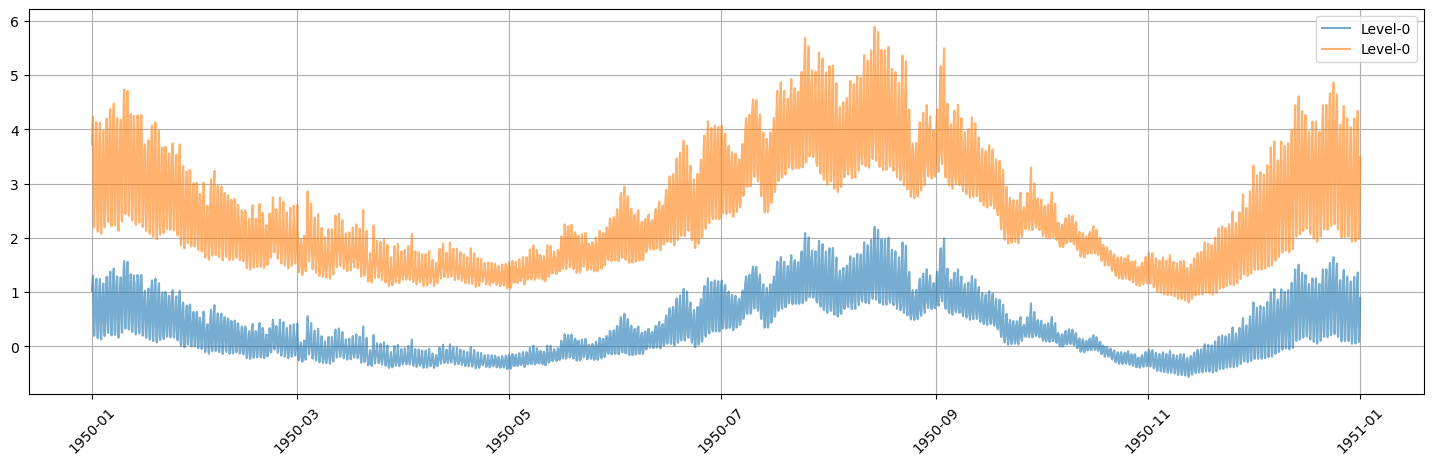

In [39]:
fig, ax = plt.subplots(1, 1, figsize=(18, 5))

ax.plot(ds5_avg.indexes['time'], ds5_avg['BCB'].isel(level=0), alpha=0.6, label='Level-0')
# ax.plot(ds5_avg.indexes['time'], ds5_avg['BCB'].isel(level=1), alpha=0.6, label='Level-1')
ax.plot(ds5_avg.indexes['time'], ds5_avg['BCB'].isel(level=2), alpha=0.6, label='Level-2')
# ax.plot(ds5_avg.indexes['time'], ds5_avg['BCB'].isel(level=3), alpha=0.6, label='Level-3')
ax.plot(ds5_avg.indexes['time'], ds5_avg['BCB'].isel(level=4), alpha=0.6, label='Level-4')
# ax.plot(ds5_avg.indexes['time'], ds5_avg['BCB'].isel(level=5), alpha=0.6, label='Level-5')
ax.plot(ds5_avg.indexes['time'], ds5_avg['BCB'].isel(level=6), alpha=0.6, label='Level-6')

ax.tick_params(axis='x', labelrotation=45)
ax.grid()

plt.legend()
plt.show()

In [16]:
def get_random_samples(data, samples=10000):
    data = data.values.ravel()
    idx = np.arange(len(data))

    rng = np.random.default_rng(42)
    rng.shuffle(idx)

    return data[idx[:samples]]

data_list = [get_random_samples(ds5_avg['BCB'].isel(level=i), samples=10000) for i in range(40)]
levels = [f'level-{i}' for i in range(40)]

In [23]:
with open('variable_statistics.json', 'r') as jf:
    st = json.load(jf)

y_avg = np.array(st['bc_conc']['avg'][:40], dtype=np.float32).reshape(40, 1)
y_std = np.array(st['bc_conc']['avg'][:40], dtype=np.float32).reshape(40, 1)

In [3]:
def create_sequences(data_array, seq_len):
    
    X_sequences = [data_array[i:i+seq_len+1] for i in range(len(data_array) - seq_len)]
    y_sequences = [data_array[i+seq_len] for i in range(len(data_array) - seq_len)]
    return X_sequences, y_sequences

In [4]:
data_array = np.arange(20)
seq_len = 5

X, y = create_sequences(data_array, seq_len)
print(X)
print(y)

[array([0, 1, 2, 3, 4, 5]), array([1, 2, 3, 4, 5, 6]), array([2, 3, 4, 5, 6, 7]), array([3, 4, 5, 6, 7, 8]), array([4, 5, 6, 7, 8, 9]), array([ 5,  6,  7,  8,  9, 10]), array([ 6,  7,  8,  9, 10, 11]), array([ 7,  8,  9, 10, 11, 12]), array([ 8,  9, 10, 11, 12, 13]), array([ 9, 10, 11, 12, 13, 14]), array([10, 11, 12, 13, 14, 15]), array([11, 12, 13, 14, 15, 16]), array([12, 13, 14, 15, 16, 17]), array([13, 14, 15, 16, 17, 18]), array([14, 15, 16, 17, 18, 19])]
[5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]


In [66]:
data_array = np.arange(20)
seq_len = 5

sequences_x1 = np.lib.stride_tricks.sliding_window_view(data_array, (seq_len, *data_array.shape[1:])).squeeze()
sequences_y1 = data_array[seq_len:]  

sequences_x2 = [data_array[i:i+seq_len+1] for i in range(len(data_array) - seq_len)]
sequences_y2 = [data_array[i+seq_len] for i in range(len(data_array) - seq_len)]

In [28]:
data_arr = np.array(data_list)
data_arr = (data_arr - y_avg) / y_std
data_list2 = [data_arr[i] for i in range(40)]

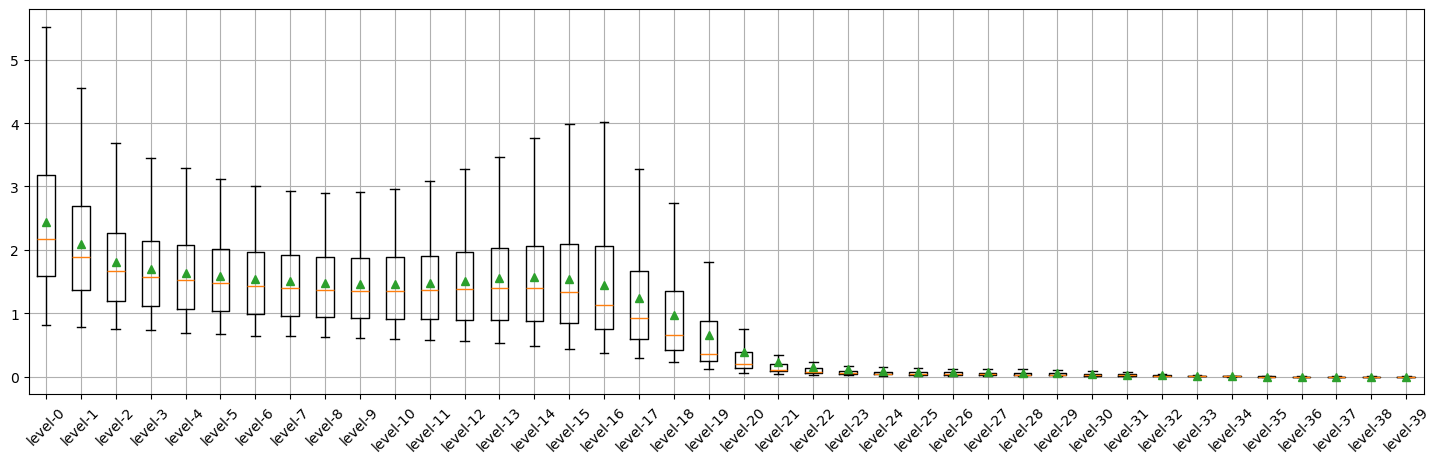

In [68]:
fig, ax = plt.subplots(figsize=(18, 5))

ax.boxplot(data_list, showmeans=True, showfliers=False)
ax.set_xticklabels(levels, rotation=45)

ax.grid()

plt.show()

In [64]:
ds5_avg = ds5.weighted(weights).mean(dim=("time")).compute()

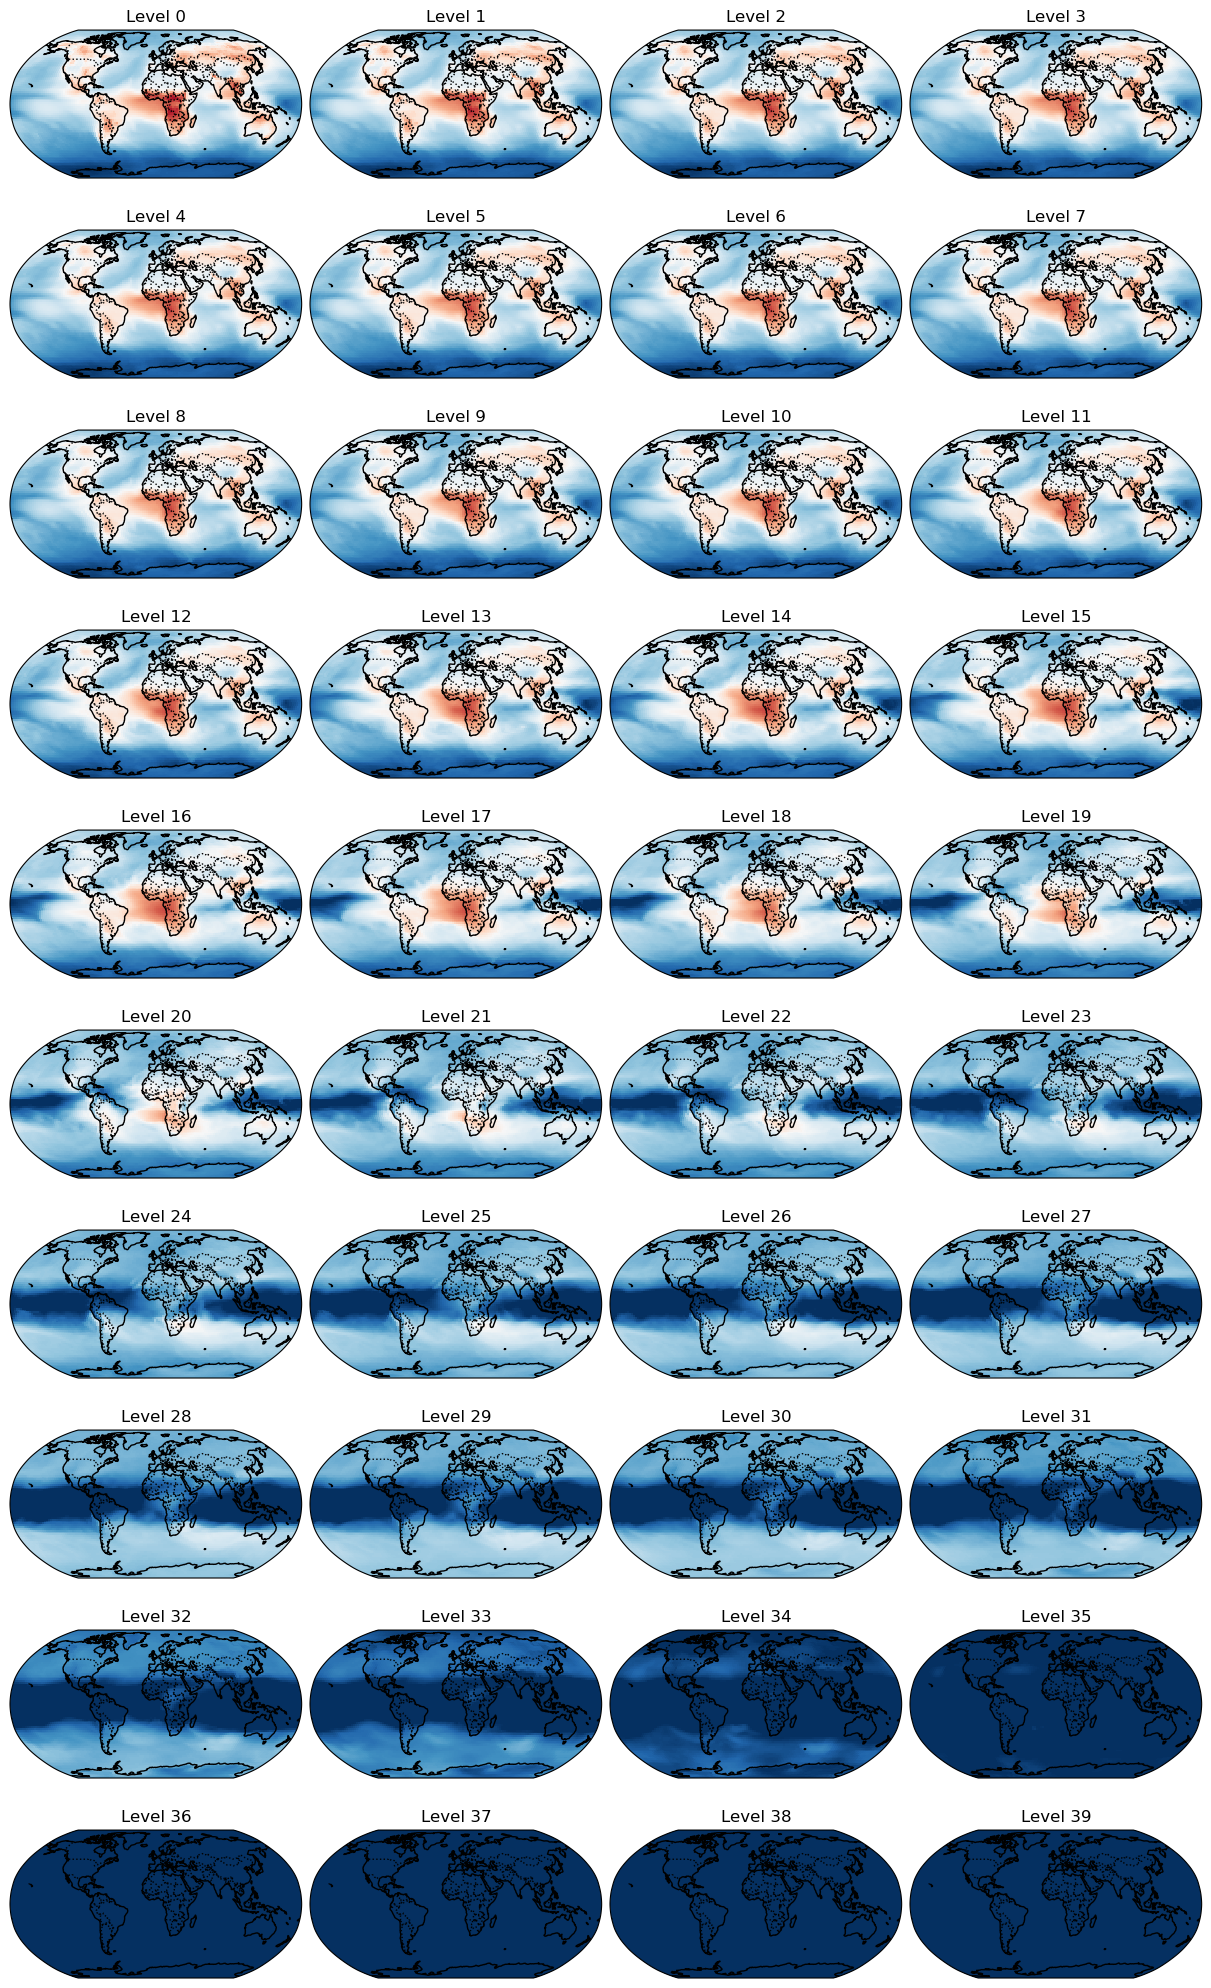

In [81]:

fig, axs = plt.subplots(ncols=4, nrows=10, figsize=(12, 20), constrained_layout=True, subplot_kw={'projection': ccrs.Robinson()})

for idx, ax in enumerate(axs.flat):
    # Plot the data
    ds5_avg['BCB'].isel(level=idx).pipe(np.log).plot(ax=ax, transform=ccrs.PlateCarree(), add_colorbar=False,
                                                         cmap='RdBu_r', vmin=-6.0, vmax=6.0)

    # Add coastlines and borders
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.set_title(f'Level {idx}')

# Show the plot
plt.show()

In [27]:
def sampelling(da, level=0):

    idx = np.arange(da.isel(level=level).size)

    rng = np.random.default_rng(0)
    rng.shuffle(idx)

    v = da.values.flatten()[idx[:10000]]
    
    return v

In [28]:
level = 0

data = {
    'u': sampelling(ds1['u'], level),
    'v': sampelling(ds1['v'], level),
    'w': sampelling(ds1['omega'], level),
    'p': sampelling(ds3['prec_3d_sum'], level),
    'b': sampelling(ds5['BCB'], level),
    'o': sampelling(ds5['OCB'], level)
}

# Create DataFrame
df = pd.DataFrame(data)

df.describe()


,u,v,w,p,b,o
count,10000.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,1.000000e+04
mean,4.793822,0.158450,0.000006,0.855915,4.138157e-01,3.468442e-01
std,16.938574,8.777670,0.000901,5.023282,5.871100e+00,4.852074e+00
min,-67.988998,-59.356232,-0.011876,0.000000,2.141442e-13,1.502120e-15
25%,-4.654706,-3.700805,-0.000076,0.000000,1.590906e-03,2.801122e-04
50%,2.364813,0.166266,0.000002,0.000000,2.070445e-03,2.930905e-04
75%,12.772251,4.201367,0.000156,0.000182,4.996161e-03,3.115023e-03
max,87.948174,46.128510,0.008881,185.324188,2.381971e+02,2.025273e+02


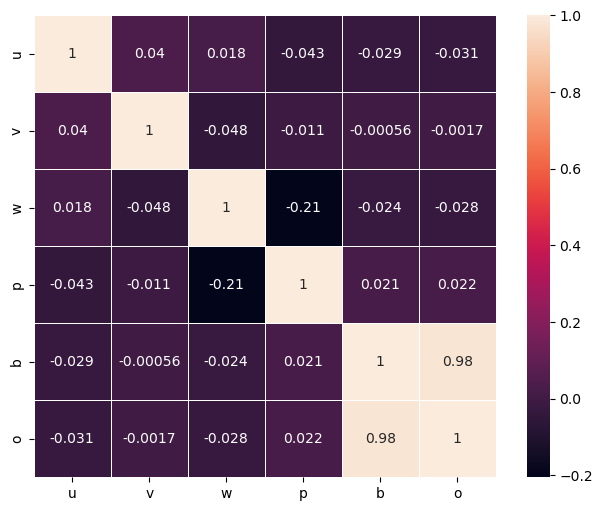

In [41]:
import seaborn as sns

# correlation matrix
corr_mat = df.corr()
fig, ax = plt.subplots(figsize=(8,6))
ax = sns.heatmap(corr_mat, square=True, annot=True, linewidths=.5)
plt.show()

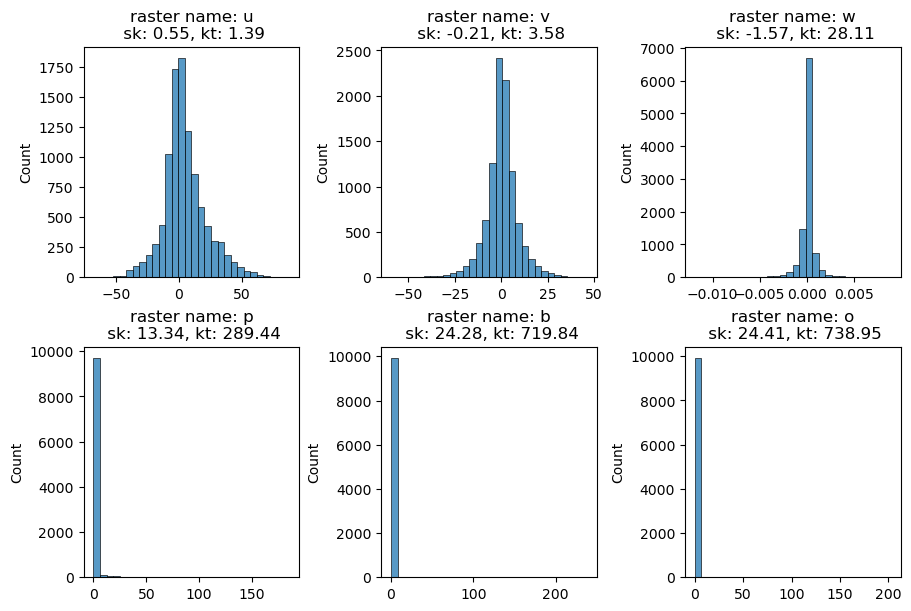

In [46]:
# Histogram
from scipy.stats import skew, kurtosis, zscore
pd.DataFrame.iteritems = pd.DataFrame.items

fig, axes = plt.subplots(nrows=2, ncols=3 , figsize=(9,6), constrained_layout=True)

for index, (column_name, column_data) in enumerate(df.iteritems()):
    i, j = divmod(index, 3)

    sns.histplot(x=column_data.values, bins=30, ax=axes[i, j])
    axes[i, j].set_title(f'raster name: {column_name}\n sk: {skew(column_data.values):.2f}, kt: {kurtosis(column_data.values):.2f}')
    axes[i, j].set_xlabel('')

# plt.savefig(f'{data_root}/results/histrograms.png')
plt.show()

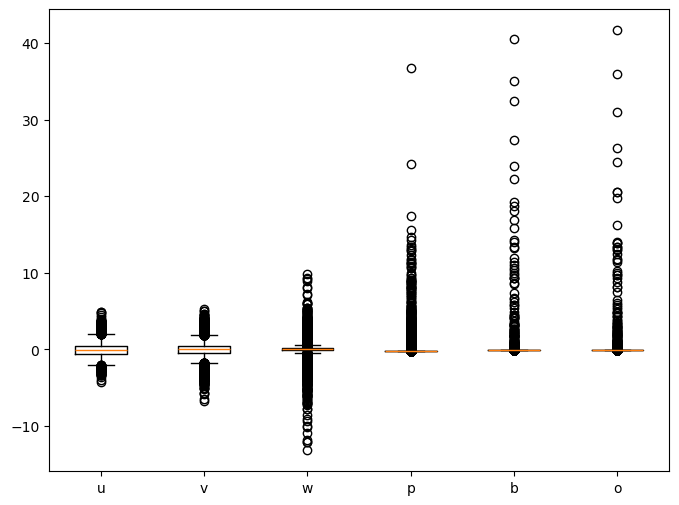

In [50]:
df_zscore = df.apply(zscore)
fig, ax = plt.subplots(figsize=(8,6))
ax.boxplot(df_zscore.values, tick_labels=df.columns, showfliers=True)
plt.show()

### Dataset

In [12]:
from torch.utils.data import Dataset
import torchvision.transforms as T
import warnings


class E33OMA(Dataset):

    def __init__(self, period, species, padding, root='/home/serfani/serfani_data0/E33OMA'):
        super(E33OMA, self).__init__()
        
        self.period  = period
        self.species = species
        self.padding = padding
        self.root    = root
        
        self._get_data_index()
    
    def _get_data_index(self):
        
        for root, dirs, files in os.walk(self.root):
            
            sorted_files = sorted(files)
            list1 = [os.path.join(root, file) for file in sorted_files if file.split(".")[1] == 'aijlh1E33oma_ai']   # Velocity Fields (time, level, lat, lon)
            # list2 = [os.path.join(root, file) for file in sorted_files if file.split(".")[1] == 'cijh1E33oma_ai']    # Precipitation (time, lat, lon)
            # list3 = [os.path.join(root, file) for file in sorted_files if file.split(".")[1] == 'taijh1E33oma_ai']   # Sea Salt Src (time, lat, lon)
            # list3 = [os.path.join(root, file) for file in sorted_files if file.split(".")[1] == 'tNDaijh1E33oma_ai'] # Clay-BCB Src (time, lat, lon)
            # list5 = [os.path.join(root, file) for file in sorted_files if file.split(".")[1] == 'taijlh1E33oma_ai']  # Aerosols Mixing Ratio (time, level, lat, lon)

        # Convert `cftime.DatetimeNoLeap` to `pandas.to_datetime()`
        warnings.filterwarnings("ignore", message="Converting a CFTimeIndex with dates from a non-standard calendar")
        datetimeindex = xr.open_mfdataset(list1[:365]).indexes['time'].to_datetimeindex()

        idx = np.arange(len(datetimeindex))
        rng = np.random.default_rng(0)
        rng.shuffle(idx)
        
        if   self.period == 'train':
            self.datetimeindex = datetimeindex[idx[:12264]] # 70%
        
        elif self.period == 'val':
            self.datetimeindex = datetimeindex[idx[12264:]] # 30%
        
        elif self.period == 'test':
            self.datetimeindex = xr.open_mfdataset(list1[365:]).indexes['time'].to_datetimeindex()

    def __getitem__(self, index):
        
        timestep = self.datetimeindex[index].strftime('%Y%m%d')
        
        ds1 = xr.open_dataset(os.path.join(self.root, f'{timestep}.aijlh1E33oma_ai.nc'))
        ds1['time'] = ds1.indexes['time'].to_datetimeindex()
        
        ds2 = xr.open_dataset(os.path.join(self.root, f'{timestep}.cijh1E33oma_ai.nc'))
        ds2['time'] = ds2.indexes['time'].to_datetimeindex()

        X1 = np.expand_dims(ds1['u'].isel(level=0).sel(time=self.datetimeindex[index]), axis=0)
        X2 = np.expand_dims(ds1['v'].isel(level=0).sel(time=self.datetimeindex[index]), axis=0)
        X3 = np.expand_dims(ds1['omega'].isel(level=0).sel(time=self.datetimeindex[index]), axis=0)

        X4 = np.expand_dims(ds2['prec'].sel(time=self.datetimeindex[index]), axis=0)

        with open('variable_statistics.json', 'r') as jf:
            vs = json.load(jf)
        
        X1_mean = vs['u']['mean'];    X1_std = vs['u']['std']
        X2_mean = vs['v']['mean'];    X2_std = vs['v']['std']
        X3_mean = vs['w']['mean'];    X3_std = vs['w']['std']
        X4_mean = vs['prec']['mean']; X4_std = vs['prec']['std']

        if self.species == 'seasalt':
            # Add positive lag for target variable
            ds3 = xr.open_dataset(os.path.join(self.root, f'{timestep}.taijh1E33oma_ai.nc'))
            ds3['time'] = ds3.indexes['time'].to_datetimeindex()

            ds4 = xr.open_dataset(os.path.join(self.root, f'{timestep}.taijlh1E33oma_ai.nc'))
            ds4['time'] = ds4.indexes['time'].to_datetimeindex()

            X5 = np.expand_dims(ds3['seasalt1_ocean_src'].sel(time=self.datetimeindex[index]), axis=0)
            y  = np.expand_dims(ds4['seasalt1'].isel(level=0).sel(time=self.datetimeindex[index]), axis=0)

            X5_mean = vs['ss_src']['mean']; X5_std = vs['ss_src']['std']
            y_mean  = vs['ss_conc']['mean']; y_std = vs['ss_conc']['std']

        if self.species == 'clay':
            # Add positive lag for target variable
            ds3 = xr.open_dataset(os.path.join(self.root, f'{timestep}.tNDaijh1E33oma_ai.nc'))
            ds3['time'] = ds3.indexes['time'].to_datetimeindex()

            ds4 = xr.open_dataset(os.path.join(self.root, f'{timestep}.taijlh1E33oma_ai.nc'))
            ds4['time'] = ds4.indexes['time'].to_datetimeindex()

            X5 = np.expand_dims(ds3['Clay_emission'].sel(time=self.datetimeindex[index]), axis=0)
            y  = np.expand_dims(ds4['Clay'].isel(level=0).sel(time=self.datetimeindex[index]), axis=0)

            X5_mean = vs['c_src']['mean']; X5_std = vs['c_src']['std']
            y_mean  = vs['c_conc']['mean']; y_std = vs['c_conc']['std']

        if self.species == 'bcb':
            # Add positive lag for target variable
            ds3 = xr.open_dataset(os.path.join(self.root, f'{timestep}.tNDaijh1E33oma_ai.nc'))
            ds3['time'] = ds3.indexes['time'].to_datetimeindex()

            ds4 = xr.open_dataset(os.path.join(self.root, f'{timestep}.taijlh1E33oma_ai.nc'))
            ds4['time'] = ds4.indexes['time'].to_datetimeindex()

            X5 = np.expand_dims(ds3['BCB_biomass_src'].sel(time=self.datetimeindex[index]), axis=0)
            y  = np.expand_dims(ds4['BCB'].isel(level=0).sel(time=self.datetimeindex[index]), axis=0)

            X5_mean = vs['bc_src']['mean']; X5_std = vs['bc_src']['std']
            y_mean  = vs['bc_conc']['mean']; y_std = vs['bc_conc']['std']


        X = np.concatenate((X1, X2, X3, X4, X5), axis=0)  # (5, 90, 144)

        Xs_mean = np.array((X1_mean, X2_mean, X3_mean, X4_mean, X5_mean), dtype=np.float32).reshape(-1, 1, 1)
        Xs_std  = np.array((X1_std, X2_std, X3_std, X4_std, X5_std), dtype=np.float32).reshape(-1, 1, 1)
 
        self.y_mean = np.array(y_mean, dtype=np.float32).reshape(-1, 1, 1)
        self.y_std  = np.array(y_std, dtype=np.float32).reshape(-1, 1, 1)

        X = (X - Xs_mean) / Xs_std
        y = (y -  self.y_mean) / self.y_std

        if self.padding:
            w = X.shape[2] # width
            h = X.shape[1] # height
            
            top_pad   = self.padding - h
            right_pad = self.padding - w
            
            X = np.lib.pad(X, ((0, 0), (top_pad, 0), (0, right_pad)), mode='constant', constant_values=0)
        
        X = torch.from_numpy(X).type(torch.float32) # torch image: C x H x W
        y = torch.from_numpy(y).type(torch.float32) # torch image: C x H x W

        return X, y
        
    def __len__(self):
        return len(self.datetimeindex)

### Add a new padding strategy 

In [7]:
import numpy as np

def cyclic_padding(data, padding):
    
    W = data.shape[2] # longitude
    
    # Define the amount of padding required
    pad_left = (padding - W) // 2  # Padding on the left side
    pad_right = padding - W - pad_left  # Padding on the right side

    if (pad_left <= W) and (pad_right <= W):
        
        # Cyclically extend data along the longitude
        return np.concatenate([data[..., -pad_left:], data, data[..., :pad_right]], axis=2)
    
    raise AttributeError(f"The requested padding size is larger than width size of the input image.")

def reflective_padding(data, padding):

    H = data.shape[1] # latitude

    # Define the amount of padding required
    pad_top = (padding - H) // 2  # Padding on the top
    pad_bottom = padding - H - pad_top  # Padding on the bottom

    pad_top += 1
    pad_bottom += 1

    if (pad_top <= H) and (pad_bottom <= H):
        
        # Reflect data at the latitude boundaries
        return np.concatenate((np.fliplr(data[:, 1:pad_top]), data, np.fliplr(data[:, -pad_bottom:-1])), axis=1)
    
    raise AttributeError(f"The requested padding size is larger than height size of the input image.")

def padding_data(data, padding):
    data = cyclic_padding(data, padding)
    data = reflective_padding(data, padding)

    return data
    

In [8]:
data = np.arange(25).reshape(1, 5, 5)
print(data)

print(padding_data(data, 13))
padding_data(data, 13).shape

[[[ 0  1  2  3  4]
  [ 5  6  7  8  9]
  [10 11 12 13 14]
  [15 16 17 18 19]
  [20 21 22 23 24]]]
[[[21 22 23 24 20 21 22 23 24 20 21 22 23]
  [16 17 18 19 15 16 17 18 19 15 16 17 18]
  [11 12 13 14 10 11 12 13 14 10 11 12 13]
  [ 6  7  8  9  5  6  7  8  9  5  6  7  8]
  [ 1  2  3  4  0  1  2  3  4  0  1  2  3]
  [ 6  7  8  9  5  6  7  8  9  5  6  7  8]
  [11 12 13 14 10 11 12 13 14 10 11 12 13]
  [16 17 18 19 15 16 17 18 19 15 16 17 18]
  [21 22 23 24 20 21 22 23 24 20 21 22 23]
  [16 17 18 19 15 16 17 18 19 15 16 17 18]
  [11 12 13 14 10 11 12 13 14 10 11 12 13]
  [ 6  7  8  9  5  6  7  8  9  5  6  7  8]
  [ 1  2  3  4  0  1  2  3  4  0  1  2  3]]]


(1, 13, 13)

In [13]:
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", message="Converting a CFTimeIndex with dates from a non-standard calendar")
    
    dataset = E33OMA(period='test', species='bcb', padding=256)

    print(len(dataset))
    dataiter = iter(dataset)
    X, y = next(dataiter)
    print(X.shape, y.shape)

17520
torch.Size([5, 256, 256]) torch.Size([1, 90, 144])


In [1]:
import os
import json
import warnings
import os.path as osp

import numpy as np
import xarray as xr

import torch
from torch.utils.data import Dataset

class E33OMAPAD(Dataset):

    def __init__(self, period, species, padding):
        super(E33OMAPAD, self).__init__()
        
        self.period  = period
        self.species = species
        self.padding = padding

    def _cyclic_padding(self, data):
    
        W = data.shape[3] # longitude

        # Define the amount of padding required
        pad_left = (self.padding[1] - W) // 2  # Padding on the left side
        pad_right = self.padding[1] - W - pad_left  # Padding on the right side

        if (pad_left <= W) and (pad_right <= W):
            
            # Cyclically extend data along the longitude
            return np.concatenate([data[..., -pad_left:], data, data[..., :pad_right]], axis=3)
        
        raise AttributeError(f"The requested padding size is larger than width size of the input image.")

    def _reflective_padding(self, data):

        H = data.shape[2] # latitude
        
        # Define the amount of padding required
        pad_top = (self.padding[0] - H) // 2  # Padding on the top
        pad_bottom = self.padding[0] - H - pad_top  # Padding on the bottom

        pad_top    += 1
        pad_bottom += 1

        if (pad_top <= H) and (pad_bottom <= H):
            
            # Reflect data at the latitude boundaries
            return np.concatenate((np.fliplr(data[:, :, 1:pad_top]), data, np.fliplr(data[:, :, -pad_bottom:-1])), axis=2)
        
        raise AttributeError(f"The requested padding size is larger than height size of the input image.")

    def _padding_data(self, data):
        data = self._cyclic_padding(data)
        data = self._reflective_padding(data)
        return data


In [4]:
class E33OMACRNN(E33OMAPAD):
    
    def __init__(self, period, species, padding, sequence_length=10, root='/home/serfani/serfani_data0/E33OMA-90Days.nc'):
        super(E33OMACRNN, self).__init__(period, species, padding)
        self.seq_len = sequence_length
        self.root    = root
    
        self._get_data()
    
    def _get_data(self):
        
        ds = xr.open_dataset(self.root)

        self.lat = ds.indexes['lat']
        self.lon = ds.indexes['lon']
        
        # Add negative lag for input features
        X1 = ds['u'].isel(level=0).values
        X2 = ds['v'].isel(level=0).values
        X3 = ds['omega'].isel(level=0).values
        X4 = ds['prec'].values

        if self.species == 'seasalt':
            # Add positive lag for target variable
            y  = ds['seasalt_conc'].isel(level=0).values
            X5 = ds['seasalt_src'].values
        
        if self.species == 'clay':
            y  = ds['clay_conc'].isel(level=0).values
            X5 = ds['clay_src'].values
            
        if self.species == 'bcb':
            y  = ds['bcb_conc'].isel(level=0).values
            X5 = ds['bcb_src'].values
        
        Xs = np.stack([X1, X2, X3, X4, X5], axis=1) # (4320, 5, 90, 144)
                
        self.y_mean = y[:3023, ...].mean().reshape(-1, 1, 1)
        self.y_std  = y[:3023, ...].std().reshape(-1, 1, 1)
        
        self.X_mean = Xs[:3023, ...].mean(axis=(0, 2, 3)).reshape(-1, 1, 1) 
        self.X_std  = Xs[:3023, ...].std(axis=(0, 2, 3)).reshape(-1, 1, 1)

        Xs = (Xs - self.X_mean) / self.X_std
        y  = (y  - self.y_mean) / self.y_std

        X = self.create_sequences(Xs) # (seq_len, 5, 90 + (2xpadding), 144 + (2xpadding))
        y = y[self.seq_len - 1:]

        if self.period == "train": # 70% of the total data
            self.y = y[:3023, ...]
            self.X = X[:3023, ...]
            
        elif self.period == "val": # 10% of the total data
            self.y = y[3023:3455, ...]
            self.X = X[3023:3455, ...]
            
        elif self.period == "test": # 20% of the total data
            self.y = y[3455:, ...]
            self.X = X[3455:, ...]
            self.datetimeindex = ds.indexes['time'][3455 + self.seq_len - 1:] # Add positive lag for target variable
        
    def create_sequences(self, data_array):
        # Use sliding_window_view to create sequences
        return np.lib.stride_tricks.sliding_window_view(data_array, (self.seq_len, *data_array.shape[1:])).squeeze()

    def __getitem__(self, index):
        
        X = np.array(self.X[index, ...], copy=True)
        y = np.array(self.y[index, ...], copy=True)

        if self.padding:
            X = self._padding_data(X) # (seq_len, 5, 90 + (2xpadding), 144 + (2xpadding))

        X = torch.from_numpy(X).type(torch.float32) # torch image: (sequence_length, channels, height, width)
        y = torch.from_numpy(y).type(torch.float32) # torch image: (sequence_length, channels, height, width)

        return X, y
           
    def __len__(self):
        return len(self.y)

In [5]:
dataset = E33OMACRNN(period='test', species='bcb', padding=(100, 154), sequence_length=10)

dataiter = iter(dataset)

X, y = next(dataiter)

print(len(dataset))
print(X.shape, y.shape)
print(dataset.datetimeindex)

856
torch.Size([10, 5, 100, 154]) torch.Size([90, 144])
DatetimeIndex(['1950-03-14 04:15:00', '1950-03-14 04:45:00',
               '1950-03-14 05:15:00', '1950-03-14 05:45:00',
               '1950-03-14 06:15:00', '1950-03-14 06:45:00',
               '1950-03-14 07:15:00', '1950-03-14 07:45:00',
               '1950-03-14 08:15:00', '1950-03-14 08:45:00',
               ...
               '1950-03-31 19:15:00', '1950-03-31 19:45:00',
               '1950-03-31 20:15:00', '1950-03-31 20:45:00',
               '1950-03-31 21:15:00', '1950-03-31 21:45:00',
               '1950-03-31 22:15:00', '1950-03-31 22:45:00',
               '1950-03-31 23:15:00', '1950-03-31 23:45:00'],
              dtype='datetime64[ns]', name='time', length=856, freq=None)


In [16]:
from model import ConvLSTM
model = ConvLSTM(5, 10, 3, 2)

model(X.unsqueeze(0))[:, :, 5:90+5, 5:144+5].shape

torch.Size([1, 1, 90, 144])

### Add Static Attributes to the dataloader

In [4]:
from datetime import datetime, timedelta

# Define a function to convert fractional years to readable dates
def fractional_year_to_date(fractional_year):
    year = int(fractional_year)
    days_in_year = (fractional_year - year) * 365  # Approximation assuming 365 days in a year
    date = datetime(year, 1, 1) + timedelta(days_in_year)
    return date

In [9]:
# ever_br_early, ever_nd_early, cold_br_early, crops_herb, crops_woody -> zero values
ds1 = xr.open_dataset('/home/serfani/serfani_data1/static_attrs/V144x90_EntMM16_lc_max_trimmed_scaled_nocrops.ext.nc', decode_times=False)
ds2 = xr.open_dataset('/home/serfani/serfani_data1/static_attrs/V144x90_EntMM16_lai_trimmed_scaled_ext.nc', decode_times=False)

# Iterate through the variables and print their attributes
for var_name, var_data in ds1.data_vars.items():
    print(f"Variable: {var_name}, {var_data.min():.2f}, {var_data.max():.2f}")

Variable: ever_br_early, 0.00, 0.00
Variable: ever_br_late, 0.00, 1.00
Variable: ever_nd_early, 0.00, 0.00
Variable: ever_nd_late, 0.00, 1.00
Variable: cold_br_early, 0.00, 0.00
Variable: cold_br_late, 0.00, 1.00
Variable: drought_br, 0.00, 0.99
Variable: decid_nd, 0.00, 1.00
Variable: cold_shrub, 0.00, 1.00
Variable: arid_shrub, 0.00, 1.00
Variable: c3_grass_per, 0.00, 1.00
Variable: c4_grass, 0.00, 1.00
Variable: c3_grass_ann, 0.00, 1.00
Variable: c3_grass_arct, 0.00, 1.00
Variable: crops_herb, 0.00, 0.00
Variable: crops_woody, 0.00, 0.00
Variable: bare_bright, 0.00, 0.93
Variable: bare_dark, 0.00, 0.70


In [10]:
ds1 = ds1.drop_vars(['ever_br_early', 'ever_nd_early', 'cold_br_early', 'crops_herb', 'crops_woody'])
ds2 = ds2.drop_vars(['ever_br_early', 'ever_nd_early', 'cold_br_early', 'crops_herb', 'crops_woody'])

In [3]:
for root, dirs, files in os.walk('/home/serfani/serfani_data1/E33OMA'):
    
    sorted_files = sorted(files)
    ds_list = [os.path.join(root, file) for file in sorted_files if (file.split(".")[1] == 'xaijE33oma_ai' and file.split(".")[0] in ['ANN1950', 'ANN1951'])]

ds3 = xr.open_mfdataset(ds_list, decode_times=False).isel(time=0).drop_vars('time')
ds3 = ds3[['axyp', 'landfr', 'ocnfr']] # 'oicefr'

In [6]:
ds_list

['/home/serfani/serfani_data1/E33OMA/ANN1950.xaijE33oma_ai.nc',
 '/home/serfani/serfani_data1/E33OMA/ANN1951.xaijE33oma_ai.nc']

In [13]:
# Iterate through the variables and print their attributes
rename_dict = {}
for var_name, var_data in ds2.data_vars.items():
    rename_dict[f'{var_name}'] = f'lai_{var_name}'

# Rename the variables
ds2_renamed = ds2.rename(rename_dict)
ds2_renamed

<xarray.Dataset> Size: 8MB
Dimensions:            (lon: 144, lat: 90, time: 12)
Coordinates:
  * lon                (lon) float32 576B -178.8 -176.2 -173.8 ... 176.2 178.8
  * lat                (lat) float32 360B -89.0 -87.0 -85.0 ... 85.0 87.0 89.0
  * time               (time) int32 48B 1 2 3 4 5 6 7 8 9 10 11 12
Data variables: (12/13)
    lai_ever_br_late   (time, lat, lon) float32 622kB ...
    lai_ever_nd_late   (time, lat, lon) float32 622kB ...
    lai_cold_br_late   (time, lat, lon) float32 622kB ...
    lai_drought_br     (time, lat, lon) float32 622kB ...
    lai_decid_nd       (time, lat, lon) float32 622kB ...
    lai_cold_shrub     (time, lat, lon) float32 622kB ...
    ...                 ...
    lai_c3_grass_per   (time, lat, lon) float32 622kB ...
    lai_c4_grass       (time, lat, lon) float32 622kB ...
    lai_c3_grass_ann   (time, lat, lon) float32 622kB ...
    lai_c3_grass_arct  (time, lat, lon) float32 622kB ...
    lai_bare_bright    (time, lat, lon) float32 622kB ...
    lai_bare_dark      (time, lat, lon) float32 622kB ...
Attributes:
    xlabel:       Monthly Leaf Area Index, 16 plant types, EXT1, m^2 leaf/m^2...
    history:      MODIS, Average of 2001-2005, Version 4, March 2014
    institution:  NASA/GISS  N.Kiang, I.Aleinov

In [14]:
# Assign the lat values from ds3 to ds1
ds1['lat'] = ds3['lat'].values
ds2_renamed['lat'] = ds3['lat'].values

In [19]:
# Merge the datasets
merged_ds = xr.merge([ds1, ds3, ds2_renamed]).chunk({'lat': 90, 'lon': 144, 'time': 1})
merged_ds.to_netcdf('/home/serfani/serfani_data1/static_attrs/static_attrs.nc')

### Adding Monthly Attributes

In [ ]:
monthly_attributes= ['axyp', 'landfr', 'oclkicefr', 'pwatfr', 'soilfr', 'vsfr', 'snowicefr', 'wtbl_depth', 'sss', 'prsurfq', 'pot_evap']

for root, dirs, files in os.walk('/discover/nobackup/sebauer1/E33oma_ai/output/'):
    
    sorted_files = sorted(files)
    ds_ma_list = [os.path.join(root, file) for file in sorted_files if file.split(".")[1] == 'xaijE33oma_ai']

ds_ma = xr.open_mfdataset(ds_ma_list, decode_times=False)

In [ ]:
ds_ma = ds_ma[monthly_attributes]
ds_ma['time'] = [fractional_year_to_date(date) for date in ds_ma['time'].values]

In [ ]:
df1 = ds1.to_dataframe(dim_order=['lat', 'lon', 'time']).reset_index()
df1['month'] = df1['time'].dt.month

In [ ]:
df2 = ds_ma.to_dataframe(dim_order=['lat', 'lon', 'time']).reset_index()
df2['month'] = df2['time'].dt.month

In [ ]:
df = pd.merge(df1, df2, on=['lat', 'lon', 'month'], how='left')
df.rename({'time_x': 'time_hr', 'seasalt_x': 'seasalt_hr', 'time_y': 'time_mn', 'seasalt_y': 'seasalt_mn'}, axis=1, inplace=True)
df.info()